In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats.stats import pearsonr
from IPython.display import display, Markdown, Latex
plt.style.use('ggplot')
from datetime import date
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm
from seaborn_qqplot import pplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas

data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_13236/4142588568.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# Update mobility variables

In [2]:
#income and age added in census folder notebook before continuing here
mob_vars = pd.read_csv(data_path + 'mobility_heat/mob_vars_final_clean_90_v1.csv')
#relative_heat = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/relative_heat_scores.csv')

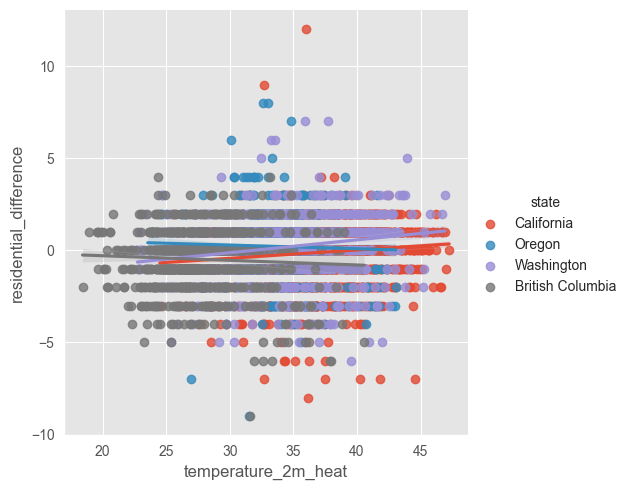

In [3]:
sns.lmplot(mob_vars, x='temperature_2m_heat', y='residential_difference', hue='state')

In [4]:
mob_vars['date'] = pd.to_datetime(mob_vars['date'])

In [5]:
mob_vars['month'] = [x.month for x in mob_vars['date']]

### Add winter temperatures

In [6]:
winter = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/winter_v2.csv')

In [7]:
mob_vars = mob_vars.merge(winter[['location', 'temperature_2m_winter']])

### Build >=5 duration variable

In [8]:
mob_vars['heatwave_dur'] = ['<5 days' if x<5 else '>=5 days' for x in mob_vars['Heat Wave Duration']]
mob_vars['hw_dur_>=_5'] = [0 if x=='<5 days' else 1 for x in mob_vars['heatwave_dur']]

### Get stage_frac variables

In [9]:
mob_vars['stage_frac'] = mob_vars['stage'] / mob_vars['Heat Wave Duration'] * 100


In [10]:
mob_vars['stage_frac'].describe()


count    6100.000000
mean       63.878364
std        28.344134
min         9.090909
25%        40.000000
50%        62.500000
75%       100.000000
max       100.000000
Name: stage_frac, dtype: float64

In [11]:
mob_vars.to_csv(data_path + 'mobility_heat/final_premultivariate_clean_90_v1.csv')

# Add/prepare final variables multivariate


In [12]:
mob_vars = pd.read_csv(data_path + 'mobility_heat/final_premultivariate_clean_90_v1.csv')

## Merge coastal 

In [13]:
coast_variable = pd.read_csv(data_path + 'mobility_heat/multivariate_modelling_v25.csv')
coast_variable.drop_duplicates('location', inplace=True)

In [14]:
mob_vars = mob_vars.merge(coast_variable[['location', 'coast_binary']], on='location')

In [15]:
df = mob_vars.copy()

### Remove Outliers

In [16]:
df['workplaces_difference'] = [np.nan if abs(x) >= df['workplaces_difference'].mean() + (4 * df['workplaces_difference'].std()) else x for x in df['workplaces_difference'] ]

df['residential_difference'] = [np.nan if abs(x) >= df['residential_difference'].mean() + (4 * df['residential_difference'].std()) else x for x in df['residential_difference'] ]

df['grocery_pharmacy_difference'] = [np.nan if abs(x) >= df['grocery_pharmacy_difference'].mean() + (4 * df['grocery_pharmacy_difference'].std()) else x for x in df['grocery_pharmacy_difference'] ]

df['parks_difference'] = [np.nan if abs(x)>= df['parks_difference'].mean() + (4 * df['parks_difference'].std()) else x for x in df['parks_difference'] ]

df['retail_difference'] = [np.nan if abs(x) >= df['retail_difference'].mean() + (4 * df['retail_difference'].std()) else x for x in df['retail_difference'] ]

df['transit_difference'] = [np.nan if abs(x) >= df['transit_difference'].mean() + (4 * df['transit_difference'].std()) else x for x in df['transit_difference'] ]

#v13
df.dropna(how='all', subset=['workplaces_difference', 'residential_difference', 'transit_difference', 'grocery_pharmacy_difference', 'parks_difference', 'retail_difference'], inplace=True)

### Center heat wave temperature variable

In [17]:
df['heat_temp_centered'] = df['temperature_2m_heat'] - df['temperature_2m_heat'].mean()


### Get Large city Variables

In [18]:
df['large_city'] = [x if x in ['Los Angeles County', 'San Diego County', 'Santa Clara County', 'San Francisco County', 'Sacramento County', 'King County', 'Multnomah County', 'Greater Vancouver'] else 'nonmajor' for x  in df['county']]

### Get coast binary as digit

In [19]:
df['coast_binary'] = df['coast_binary'] * 1

### Get June heatwave variable

In [20]:
df = df[['temperature_2m_heat', 'month', 'date_heat', 'control_day', 'Heat Wave Duration', 'large_city', 'date', 'location', 'heat_ID_x', 'workplaces_difference', 'residential_difference', 'grocery_pharmacy_difference', 'retail_difference', 'parks_difference', 'transit_difference', 'state', 'year', 'weekend', 'stage_frac', 'heatwave_dur', 'temp_diff', 'heat_temp_centered', 'coast_binary', 'temperature_2m_winter', 'income_dec', 'over65_dec', 'nonwhite_dec','large_city', 'popdens_dec']]

In [21]:
df['index'] = range(0, len(df))

In [22]:
df['date'] = pd.to_datetime(df['date'])

In [23]:
df['month'] = [x.month for x in df['date']]

In [24]:
df['month'].unique()

array([6, 7, 8, 9])

In [25]:
df['june_hw'] = df.groupby(['heat_ID_x'])['month'].transform(lambda x: 6 in x.unique())
df['june_hw'] = df['june_hw'] * 1



In [26]:
df['month'].value_counts()

8    2347
7    2189
9     796
6     754
Name: month, dtype: int64

In [27]:
df.rename(columns={'heat_ID_x': 'heat_ID'}, inplace=True)

In [28]:
df.reset_index(inplace=True, drop=True)

In [29]:
df['temperature_2m_heat'].describe()

count    6086.000000
mean       33.392871
std         5.037908
min        18.414703
25%        29.775768
50%        33.688816
75%        36.818149
max        47.254585
Name: temperature_2m_heat, dtype: float64

In [30]:
df.to_csv(data_path + 'mobility_heat/final_multivariate_clean_90_v1.csv')

In [218]:
df

,temperature_2m_heat,month,date_heat,control_day,Heat Wave Duration,large_city,date,location,heat_ID,workplaces_difference,...,heat_temp_centered,coast_binary,temperature_2m_winter,income_dec,over65_dec,nonwhite_dec,large_city,popdens_dec,index,june_hw
0,34.180952,6,2020-06-03,2020-05-20,2.0,nonmajor,2020-06-03,"Alameda County, California",9b743974-14fe-490d-8a80-72dda72ee8a6,2.0,...,0.788082,0,9.731907,10,3,10,nonmajor,10,0,1
1,33.802157,6,2020-06-04,2020-05-28,2.0,nonmajor,2020-06-04,"Alameda County, California",9b743974-14fe-490d-8a80-72dda72ee8a6,0.0,...,0.409286,0,9.731907,10,3,10,nonmajor,10,1,1
2,33.723932,7,2020-07-11,2020-06-27,2.0,nonmajor,2020-07-11,"Alameda County, California",467bc8d5-b537-4f2c-a537-bd22499bdeb0,0.0,...,0.331061,0,9.731907,10,3,10,nonmajor,10,2,0
3,34.195656,7,2020-07-12,2020-07-05,2.0,nonmajor,2020-07-12,"Alameda County, California",467bc8d5-b537-4f2c-a537-bd22499bdeb0,2.0,...,0.802785,0,9.731907,10,3,10,nonmajor,10,3,0
4,33.705415,8,2020-08-13,2020-08-06,7.0,nonmajor,2020-08-13,"Alameda County, California",37d1e68c-a479-4cb6-b238-1f31feeaedac,-1.0,...,0.312544,0,9.731907,10,3,10,nonmajor,10,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6081,27.086876,8,2022-08-19,2022-08-05,3.0,nonmajor,2022-08-19,"Thompson-Nicola, British Columbia",61efe35c-2a30-4e0f-92ba-ce2530024734,0.0,...,-6.305995,0,-7.356643,6,5,6,nonmajor,6,6081,0
6082,26.801616,8,2022-08-30,2022-08-23,2.0,nonmajor,2022-08-30,"Thompson-Nicola, British Columbia",bfaa734a-bcc0-41af-993e-d8262856f313,1.0,...,-6.591255,0,-7.356643,6,5,6,nonmajor,6,6082,0
6083,28.312593,8,2022-08-31,2022-09-07,2.0,nonmajor,2022-08-31,"Thompson-Nicola, British Columbia",bfaa734a-bcc0-41af-993e-d8262856f313,-2.0,...,-5.080278,0,-7.356643,6,5,6,nonmajor,6,6083,0
6084,28.116546,9,2022-09-02,2022-09-09,2.0,nonmajor,2022-09-02,"Thompson-Nicola, British Columbia",f3903e75-2b79-4328-befc-4cb40e5ae1cf,-8.0,...,-5.276325,0,-7.356643,6,5,6,nonmajor,6,6084,0


In [219]:
df.groupby('year')['workplaces_difference'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2020,1300.0,-0.751538,2.597557,-14.0,-2.0,-1.0,1.0,13.0
2021,2328.0,-1.320017,3.951282,-17.0,-3.0,-1.0,1.0,13.0
2022,2313.0,0.419369,3.409051,-16.0,-1.0,0.0,2.0,16.0


In [150]:
df.groupby('year')[['residential_difference', 'workplaces_difference', 'transit_difference', 'grocery_pharmacy_difference', 'retail_difference', 'parks_difference']].mean()

,residential_difference,workplaces_difference,transit_difference,grocery_pharmacy_difference,retail_difference,parks_difference
year,,,,,,
2020,-0.106130,-0.751538,-0.959239,0.831313,0.144978,-0.814516
2021,0.053163,-1.320017,-1.234586,0.857968,-0.110568,-3.779425
2022,-0.190052,0.419369,0.031698,1.853409,1.122179,0.051832


In [128]:
df.columns

Index(['temperature_2m_heat', 'month', 'date_heat', 'control_day',
       'Heat Wave Duration', 'large_city', 'date', 'location', 'heat_ID',
       'workplaces_difference', 'residential_difference',
       'grocery_pharmacy_difference', 'retail_difference', 'parks_difference',
       'transit_difference', 'state', 'year', 'weekend', 'stage_frac',
       'heatwave_dur', 'temp_diff', 'heat_temp_centered', 'coast_binary',
       'temperature_2m_winter', 'income_dec', 'over65_dec', 'nonwhite_dec',
       'large_city', 'popdens_dec', 'index', 'june_hw'],
      dtype='object')

In [ ]:
0.14657   
0.04313   
0.48212   
-0.73228   
-0.25290   
8.00093   
-0.65080   
-0.36586   
5.34500   
5.82576   
-0.77237   
-0.44989   
6.19645   
6.16250   
7.86407   
-4.80964   
-7.04697   
37.37300   
37.18480   
44.10255   
323.79113   